In [76]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
import json

In [77]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

In [78]:
data = pd.read_csv("data.csv", index_col=0) 
data['visitStartTime'] = pd.to_datetime(data['visitStartTime'],unit='s')
data.head()

,visitStartTime,continent,country
0,2017-07-01 07:00:05,Americas,United States
1,2017-07-01 07:01:53,Asia,Philippines
2,2017-07-01 07:02:25,Americas,United States
3,2017-07-01 07:02:29,Americas,United States
4,2017-07-01 07:02:31,Asia,Philippines


In [79]:
data.shape

(71812, 3)

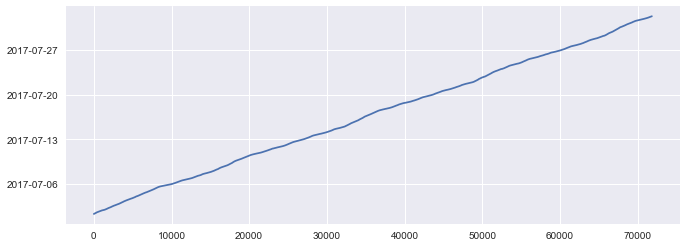

In [80]:
plt.plot(data['visitStartTime'])
plt.show()

In [81]:
data['date'] =  data['visitStartTime'].apply(lambda x: pd.Timestamp.to_pydatetime(x).date())
data['hour'] =  data['visitStartTime'].apply(lambda x: pd.Timestamp.to_pydatetime(x).hour)
data['datehour'] =  data['visitStartTime'].apply(lambda x: pd.Timestamp.to_pydatetime(x).replace(minute=0, second=0))
data['minute'] =  data['visitStartTime'].apply(lambda x: pd.Timestamp.to_pydatetime(x).replace(second=0))

data.head()

,visitStartTime,continent,country,date,hour,datehour,minute
0,2017-07-01 07:00:05,Americas,United States,2017-07-01,7,2017-07-01 07:00:00,2017-07-01 07:00:00
1,2017-07-01 07:01:53,Asia,Philippines,2017-07-01,7,2017-07-01 07:00:00,2017-07-01 07:01:00
2,2017-07-01 07:02:25,Americas,United States,2017-07-01,7,2017-07-01 07:00:00,2017-07-01 07:02:00
3,2017-07-01 07:02:29,Americas,United States,2017-07-01,7,2017-07-01 07:00:00,2017-07-01 07:02:00
4,2017-07-01 07:02:31,Asia,Philippines,2017-07-01,7,2017-07-01 07:00:00,2017-07-01 07:02:00


In [82]:
first = data[data['visitStartTime'].apply(lambda x: pd.Timestamp.to_pydatetime(x).date()) == datetime.date(2017, 7, 2)]
first.shape

(1955, 7)

In [84]:
first.head()

,visitStartTime,continent,country,date,hour,datehour,minute
1497,2017-07-02 00:00:03,Oceania,New Zealand,2017-07-02,0,2017-07-02,2017-07-02 00:00:00
1498,2017-07-02 00:01:00,Americas,Canada,2017-07-02,0,2017-07-02,2017-07-02 00:01:00
1499,2017-07-02 00:01:37,Americas,United States,2017-07-02,0,2017-07-02,2017-07-02 00:01:00
1500,2017-07-02 00:01:57,Europe,United Kingdom,2017-07-02,0,2017-07-02,2017-07-02 00:01:00
1501,2017-07-02 00:03:02,Oceania,Australia,2017-07-02,0,2017-07-02,2017-07-02 00:03:00


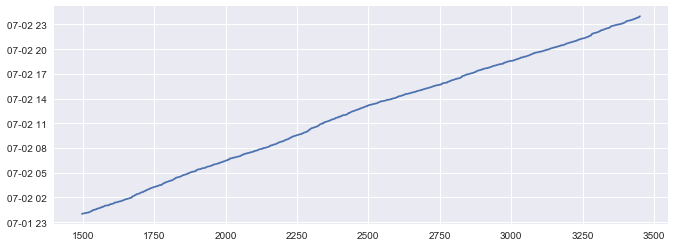

In [83]:
plt.plot(first['visitStartTime'])
plt.show()

In [ ]:
first_eu = first[first['continent'] == 'Europe']
first_eu.head()

In [ ]:
plt.plot(first_eu['visitStartTime'])
plt.show()

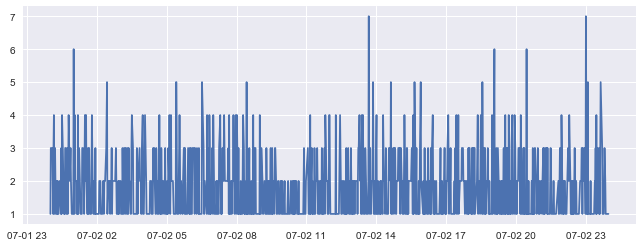

In [218]:
plt.plot(first.groupby('minute').count()['visitStartTime'])
plt.show()

In [219]:
first_scaled = first.groupby('minute').count()['visitStartTime']
first_scaled.describe()

count    1062.000000
mean        1.840866
std         1.016409
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         7.000000
Name: visitStartTime, dtype: float64

In [220]:
first_scaled.to_csv('load_realtime.csv', index=False)

In [221]:
ts = data.groupby(['datehour', 'date', 'hour']).count()['visitStartTime']

In [222]:
ts.head()

datehour             date        hour
2017-07-01 07:00:00  2017-07-01  7       73
2017-07-01 08:00:00  2017-07-01  8       59
2017-07-01 09:00:00  2017-07-01  9       70
2017-07-01 10:00:00  2017-07-01  10      73
2017-07-01 11:00:00  2017-07-01  11      67
Name: visitStartTime, dtype: int64

In [223]:
ts.shape

(744,)

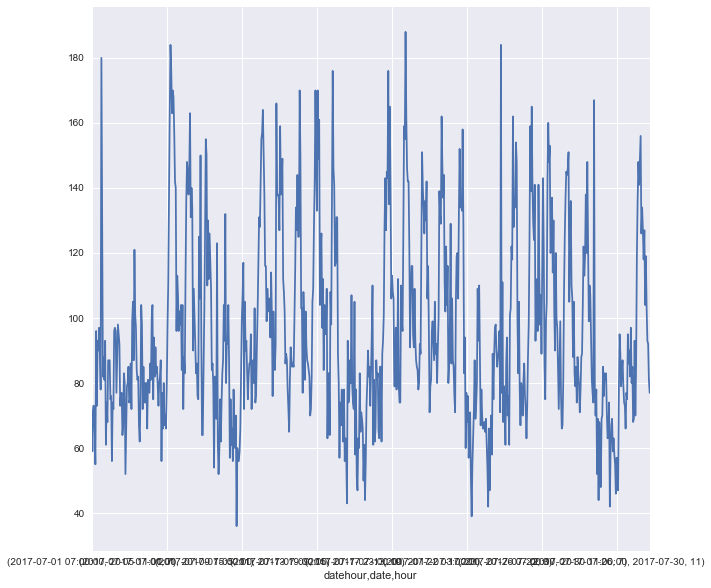

In [224]:
ts.plot(figsize=(10,10))
plt.show()

In [ ]:
pd.plotting.autocorrelation_plot(ts)
plt.show()

In [ ]:
#sns.boxplot(data=pd.DataFrame(ts), x='hour')

In [ ]:
pd.DataFrame(ts)

In [ ]:
ts.describe()

In [ ]:
ts_scaled = ts//20

In [ ]:
ts_scaled.head()

In [ ]:
ts_scaled.describe()

In [ ]:
ts_scaled.plot(figsize=(10,10))
plt.show()

In [ ]:
#ts_scaled.to_csv('load_full.csv', index=False)

# Events -> Trace

In [14]:
trace_dict = {}

for i in range(1, 31):
    with open('data/eventspart' + str(i) + '.txt') as events_file:
        events = json.load(events_file)
        for e in events['items']:
            if(e['reason']=='Created' or e['reason']=='Killing'):
                time = datetime.datetime.strptime(e['firstTimestamp'], "%Y-%m-%dT%H:%M:%SZ")
                trace_dict[e['metadata']['uid']] = [time, e['metadata']['name'], e['metadata']['name'].partition('-')[0], e['reason']]

            
trace = pd.DataFrame.from_dict(trace_dict, orient='index')
trace.columns = ['time', 'name', 'podType', 'event']

#truncate parts before and after simulation
trace = trace[trace['time'] > datetime.datetime(2020, 9, 26, 14, 15)]
trace = trace[trace['time'] < datetime.datetime(2020, 9, 27, 3, 0)]

trace.sort_values(by=['time'], inplace=True)
print('trace:')
trace.head(15)

trace:


,time,name,podType,event
ba2ad388-374d-44f6-9a1b-961f0ea60200,2020-09-26 14:16:01,loadgenerator-79bff5bd57-lf2r8.16385b08d89b2303,loadgenerator,Created
f30e145a-c883-4c06-881b-f1d6674d6219,2020-09-26 14:16:01,loadgenerator-79bff5bd57-5vstf.16385b08d8a3dbed,loadgenerator,Created
308d1ed1-4ce1-4b1e-812f-5f57c0fa6006,2020-09-26 14:17:00,loadgenerator-79bff5bd57-5vstf.16385b16ae01aebb,loadgenerator,Killing
3f9eedcd-fc67-43c2-b0f2-ab09c2c63e3d,2020-09-26 14:17:17,frontend-5fcb8cdcdc-zbpr7.16385b1a8a38d1c1,frontend,Created
96746f22-a337-4986-a062-7ca3cfa45d42,2020-09-26 14:18:01,loadgenerator-79bff5bd57-2ld9p.16385b24df9cd32b,loadgenerator,Created
1c46cef9-bbb0-4f0f-990a-d82ba870c5ce,2020-09-26 14:20:19,frontend-5fcb8cdcdc-n2g46.16385b44f3d60e66,frontend,Created
706c7d4f-76c5-4834-8183-8b460594eda9,2020-09-26 14:21:01,loadgenerator-79bff5bd57-2ld9p.16385b4eaf3f2314,loadgenerator,Killing
e290b151-d0ca-4b7c-87c5-528157543578,2020-09-26 14:22:02,loadgenerator-79bff5bd57-crpds.16385b5ce5dd590d,loadgenerator,Created
06fa4048-342f-4fa2-af4a-ae5d954d5ebe,2020-09-26 14:22:02,loadgenerator-79bff5bd57-j98kt.16385b5ce5791463,loadgenerator,Created
9ad8edb2-cee0-4027-821c-fdc461e9aa04,2020-09-26 14:23:01,loadgenerator-79bff5bd57-crpds.16385b6ab373c591,loadgenerator,Killing


In [15]:
trace.shape

(677, 4)

In [16]:
def buildMatrix(trace_p):
    matrix = pd.DataFrame(columns = ['time', 'nrLoadgenerators', 'nrFrontends'])
    stepSize = datetime.timedelta(seconds=60)
    # sort trace by time
    trace_p.sort_values(by=['time'], inplace=True)
    # assumption: starting from 0,0 config
    # first row: all 0, then increment gradually 
    firstTs = trace_p['time'].iloc[0]
    lastTs = trace_p['time'].iloc[-1]
    
    currentTime = firstTs - stepSize
    print('start:')
    print(currentTime)
    nrFrontends = 1
    nrLoadgenerators = 1
    matrix = matrix.append(pd.Series([currentTime, nrLoadgenerators, nrFrontends], index=matrix.columns), ignore_index=True)
    idx = 0


    # walk over trace + evaluate change at every step
    while(currentTime <= lastTs + stepSize):
        while(idx < len(trace_p) and trace_p['time'].iloc[idx] <= currentTime):
            if(trace_p['podType'].iloc[idx] == 'frontend' and trace_p['event'].iloc[idx] == 'Killing'):
                nrFrontends = nrFrontends - 1
            if(trace_p['podType'].iloc[idx] == 'frontend' and trace_p['event'].iloc[idx] == 'Created'):
                nrFrontends = nrFrontends + 1
            if(trace_p['podType'].iloc[idx] == 'loadgenerator' and trace_p['event'].iloc[idx] == 'Killing'):
                nrLoadgenerators = nrLoadgenerators - 1
            if(trace_p['podType'].iloc[idx] == 'loadgenerator' and trace_p['event'].iloc[idx] == 'Created'):
                nrLoadgenerators = nrLoadgenerators + 1
            idx = idx + 1
        
        currentTime = currentTime + stepSize
        matrix = matrix.append(pd.Series([currentTime, nrLoadgenerators, nrFrontends], index=matrix.columns), ignore_index=True)

    print("matrix:")
    return matrix
    #matrix.to_csv('matrix.csv')


In [17]:
matrix = buildMatrix(trace)

matrix.head()

start:
2020-09-26 14:15:01
matrix:


,time,nrLoadgenerators,nrFrontends
0,2020-09-26 14:15:01,1,1
1,2020-09-26 14:16:01,1,1
2,2020-09-26 14:17:01,3,1
3,2020-09-26 14:18:01,2,1
4,2020-09-26 14:19:01,3,2


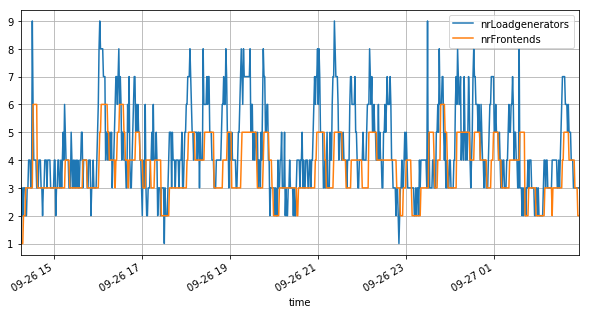

In [18]:
matrix.plot(x='time', y=['nrLoadgenerators', 'nrFrontends'], figsize=(10,5), grid=True)
plt.show()

In [31]:
matrix['nrFrontends'] = matrix['nrFrontends'].astype(float)
matrix['nrLoadgenerators'] = matrix['nrLoadgenerators'].astype(float)

column_1 = matrix["nrFrontends"]

column_2 = matrix["nrLoadgenerators"]

correlation = column_1.corr(column_2, method='spearman')
correlation

0.54469868986749237

In [20]:
matrix.dtypes

time                datetime64[ns]
nrLoadgenerators             int64
nrFrontends                  int64
dtype: object

In [21]:
trace1 = trace
trace1

,time,name,podType,event
ba2ad388-374d-44f6-9a1b-961f0ea60200,2020-09-26 14:16:01,loadgenerator-79bff5bd57-lf2r8.16385b08d89b2303,loadgenerator,Created
f30e145a-c883-4c06-881b-f1d6674d6219,2020-09-26 14:16:01,loadgenerator-79bff5bd57-5vstf.16385b08d8a3dbed,loadgenerator,Created
308d1ed1-4ce1-4b1e-812f-5f57c0fa6006,2020-09-26 14:17:00,loadgenerator-79bff5bd57-5vstf.16385b16ae01aebb,loadgenerator,Killing
3f9eedcd-fc67-43c2-b0f2-ab09c2c63e3d,2020-09-26 14:17:17,frontend-5fcb8cdcdc-zbpr7.16385b1a8a38d1c1,frontend,Created
96746f22-a337-4986-a062-7ca3cfa45d42,2020-09-26 14:18:01,loadgenerator-79bff5bd57-2ld9p.16385b24df9cd32b,loadgenerator,Created
1c46cef9-bbb0-4f0f-990a-d82ba870c5ce,2020-09-26 14:20:19,frontend-5fcb8cdcdc-n2g46.16385b44f3d60e66,frontend,Created
706c7d4f-76c5-4834-8183-8b460594eda9,2020-09-26 14:21:01,loadgenerator-79bff5bd57-2ld9p.16385b4eaf3f2314,loadgenerator,Killing
e290b151-d0ca-4b7c-87c5-528157543578,2020-09-26 14:22:02,loadgenerator-79bff5bd57-crpds.16385b5ce5dd590d,loadgenerator,Created
06fa4048-342f-4fa2-af4a-ae5d954d5ebe,2020-09-26 14:22:02,loadgenerator-79bff5bd57-j98kt.16385b5ce5791463,loadgenerator,Created
9ad8edb2-cee0-4027-821c-fdc461e9aa04,2020-09-26 14:23:01,loadgenerator-79bff5bd57-crpds.16385b6ab373c591,loadgenerator,Killing


In [22]:
trace.head(8)

,time,name,podType,event
ba2ad388-374d-44f6-9a1b-961f0ea60200,2020-09-26 14:16:01,loadgenerator-79bff5bd57-lf2r8.16385b08d89b2303,loadgenerator,Created
f30e145a-c883-4c06-881b-f1d6674d6219,2020-09-26 14:16:01,loadgenerator-79bff5bd57-5vstf.16385b08d8a3dbed,loadgenerator,Created
308d1ed1-4ce1-4b1e-812f-5f57c0fa6006,2020-09-26 14:17:00,loadgenerator-79bff5bd57-5vstf.16385b16ae01aebb,loadgenerator,Killing
3f9eedcd-fc67-43c2-b0f2-ab09c2c63e3d,2020-09-26 14:17:17,frontend-5fcb8cdcdc-zbpr7.16385b1a8a38d1c1,frontend,Created
96746f22-a337-4986-a062-7ca3cfa45d42,2020-09-26 14:18:01,loadgenerator-79bff5bd57-2ld9p.16385b24df9cd32b,loadgenerator,Created
1c46cef9-bbb0-4f0f-990a-d82ba870c5ce,2020-09-26 14:20:19,frontend-5fcb8cdcdc-n2g46.16385b44f3d60e66,frontend,Created
706c7d4f-76c5-4834-8183-8b460594eda9,2020-09-26 14:21:01,loadgenerator-79bff5bd57-2ld9p.16385b4eaf3f2314,loadgenerator,Killing
e290b151-d0ca-4b7c-87c5-528157543578,2020-09-26 14:22:02,loadgenerator-79bff5bd57-crpds.16385b5ce5dd590d,loadgenerator,Created


In [23]:
# first event: there 1, 1
# ba2ad388-374d-44f6-9a1b-961f0ea60200 	2020-09-26 14:16:01 	loadgenerator-79bff5bd57-lf2r8.16385b08d89b2303 	loadgenerator 	Created

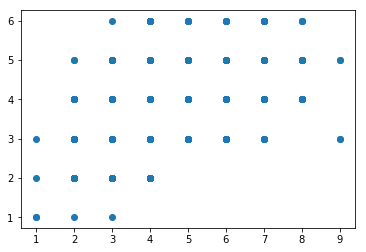

In [24]:
plt.scatter(matrix['nrLoadgenerators'], matrix['nrFrontends'])
plt.show()

In [25]:
matrix['nrFrontends'].describe()

count    762.000000
mean       3.692913
std        1.017677
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        6.000000
Name: nrFrontends, dtype: float64

In [26]:
matrix['nrLoadgenerators'].describe()

count    762.000000
mean       4.360892
std        1.529283
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        9.000000
Name: nrLoadgenerators, dtype: float64

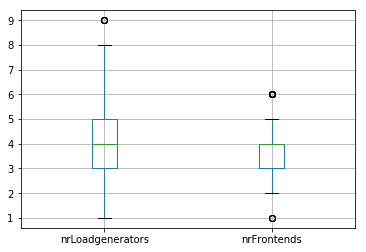

In [27]:
matrix.boxplot()
plt.show()

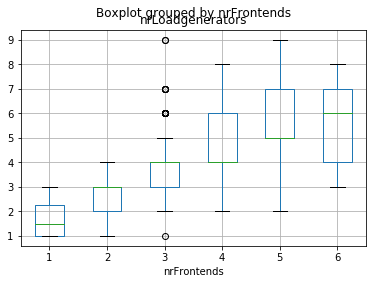

In [28]:
matrix.boxplot(column='nrLoadgenerators',by='nrFrontends')
plt.show()

In [ ]:
trace.tail(10)

In [32]:
# Correlation
import scipy.signal as ss

def ccf(x, y, lag_max = 100):

    result = ss.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)

    return result[lo:hi]


0.729049884472
97


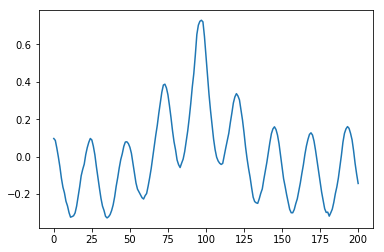

In [41]:
c = ccf(matrix['nrFrontends'], matrix['nrLoadgenerators'])
print(np.max(c))
print(np.argmax(c))
plt.plot(c)
plt.show()

In [50]:
matrix = matrix.set_index('time')
matrix.head()

,nrLoadgenerators,nrFrontends
time,,
2020-09-26 14:15:01,1,1
2020-09-26 14:16:01,1,1
2020-09-26 14:17:01,3,1
2020-09-26 14:18:01,2,1
2020-09-26 14:19:01,3,2


In [56]:
matrix.shift(periods=-1).tail()

,nrLoadgenerators,nrFrontends
time,,
2020-09-27 02:52:01,3.0,3.0
2020-09-27 02:53:01,3.0,3.0
2020-09-27 02:54:01,3.0,2.0
2020-09-27 02:55:01,3.0,2.0
2020-09-27 02:56:01,NaN,NaN


In [167]:
lagged = []
for i in range(1, 6):
    matrix_1 = matrix.shift(periods=i)
    #matrix_1['nrFrontends'] = matrix_1['nrFrontends'].astype(int)
    #matrix_1['nrLoadgenerators'] = matrix_1['nrLoadgenerators'].astype(int)
    matrix_1.columns = ['nrFrontends_' + str(i), 'nrLoadgenerators_' + str(i)]
    #print(matrix_1.head())
    lagged.append(matrix_1)
lagged.insert(0, matrix)
features = pd.concat(lagged, axis=1)

In [168]:
features['frontendChange'] = features['nrFrontends'] - features['nrFrontends_1']
features['loadChange'] = features['nrLoadgenerators'] - features['nrLoadgenerators_1']

In [169]:
features.columns

Index(['nrLoadgenerators', 'nrFrontends', 'nrFrontends_1',
       'nrLoadgenerators_1', 'nrFrontends_2', 'nrLoadgenerators_2',
       'nrFrontends_3', 'nrLoadgenerators_3', 'nrFrontends_4',
       'nrLoadgenerators_4', 'nrFrontends_5', 'nrLoadgenerators_5',
       'frontendChange', 'loadChange'],
      dtype='object')

In [170]:
features['decF'] = features['nrFrontends'] < features['nrFrontends_1']
features['incF'] = features['nrFrontends'] > features['nrFrontends_1']
features['decL'] = features['nrLoadgenerators'] < features['nrLoadgenerators_1']
features['incL'] = features['nrLoadgenerators'] > features['nrLoadgenerators_1']

features['lastIncF'] = datetime.timedelta(0)
features['lastDecF'] = datetime.timedelta(0)
features['lastIncL'] = datetime.timedelta(0)
features['lastDecL'] = datetime.timedelta(0)

lastIncF = features.index[0]
lastDecF = features.index[0]
lastIncL = features.index[0]
lastDecL = features.index[0]
for index, row in features.iterrows():
    if(row['incF']):
        lastIncF = index
    if(row['decF']):
        lastDecF = index
    if(row['incL']):
        lastIncL = index
    if(row['decL']):
        lastIncL = index
    features.at[index, 'lastIncF'] = index - lastIncF
    features.at[index, 'lastIncL'] = index - lastIncL
    features.at[index, 'lastDecF'] = index - lastDecF
    features.at[index, 'lastDecL'] = index - lastDecL


        



In [171]:
features.head()

,nrLoadgenerators,nrFrontends,nrFrontends_1,nrLoadgenerators_1,nrFrontends_2,nrLoadgenerators_2,nrFrontends_3,nrLoadgenerators_3,nrFrontends_4,nrLoadgenerators_4,...,frontendChange,loadChange,decF,incF,decL,incL,lastIncF,lastDecF,lastIncL,lastDecL
time,,,,,,,,,,,,,,,,,,,,,
2020-09-26 14:15:01,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,False,False,00:00:00,00:00:00,00:00:00,00:00:00
2020-09-26 14:16:01,1,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,False,False,False,False,00:01:00,00:01:00,00:01:00,00:01:00
2020-09-26 14:17:01,3,1,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,0.0,2.0,False,False,False,True,00:02:00,00:02:00,00:00:00,00:02:00
2020-09-26 14:18:01,2,1,3.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,-2.0,1.0,True,False,False,True,00:03:00,00:00:00,00:00:00,00:03:00
2020-09-26 14:19:01,3,2,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,...,0.0,2.0,False,False,False,True,00:04:00,00:01:00,00:00:00,00:04:00


In [172]:
features.corr(method='spearman')

,nrLoadgenerators,nrFrontends,nrFrontends_1,nrLoadgenerators_1,nrFrontends_2,nrLoadgenerators_2,nrFrontends_3,nrLoadgenerators_3,nrFrontends_4,nrLoadgenerators_4,nrFrontends_5,nrLoadgenerators_5,frontendChange,loadChange,decF,incF,decL,incL
nrLoadgenerators,1.000000,0.544699,0.734044,0.452188,0.652868,0.358558,0.561857,0.280360,0.464147,0.212965,0.417337,0.137588,-0.485796,0.721674,0.381383,-0.204064,-0.385182,0.619740
nrFrontends,0.544699,1.000000,0.643192,0.908129,0.717323,0.809448,0.730550,0.702128,0.733879,0.592326,0.710455,0.475865,0.004276,-0.084133,-0.045228,0.231614,0.254632,-0.084706
nrFrontends_1,0.734044,0.643192,1.000000,0.543737,0.733735,0.450914,0.652454,0.357839,0.561274,0.279499,0.463352,0.211983,-0.725475,0.382206,0.607200,-0.354677,-0.163571,0.298652
nrLoadgenerators_1,0.452188,0.908129,0.543737,1.000000,0.642526,0.907790,0.716880,0.809566,0.730156,0.702004,0.733493,0.591951,0.070555,-0.241248,-0.091378,0.241328,0.364192,-0.204705
nrFrontends_2,0.652868,0.717323,0.733735,0.642526,1.000000,0.542769,0.733425,0.450319,0.652036,0.357117,0.560687,0.278634,-0.334786,0.227824,0.239424,-0.116630,-0.058265,0.161705
nrLoadgenerators_2,0.358558,0.809448,0.450914,0.907790,0.542769,1.000000,0.641855,0.908125,0.716433,0.809682,0.729760,0.701877,0.110888,-0.282916,-0.118028,0.227773,0.358550,-0.244933
nrFrontends_3,0.561857,0.730550,0.652454,0.716880,0.733425,0.641855,1.000000,0.542339,0.733112,0.449721,0.651617,0.356391,-0.210888,0.077341,0.121493,-0.043999,0.011212,0.030630
nrLoadgenerators_3,0.280360,0.702128,0.357839,0.809566,0.450319,0.908125,0.542339,1.000000,0.641567,0.908059,0.716254,0.809532,0.149417,-0.303607,-0.151559,0.209205,0.341701,-0.256623
nrFrontends_4,0.464147,0.733879,0.561274,0.730156,0.652036,0.716433,0.733112,0.641567,1.000000,0.541906,0.732798,0.449119,-0.094638,-0.036107,0.028881,0.014515,0.101245,-0.041202
nrLoadgenerators_4,0.212965,0.592326,0.279499,0.702004,0.357117,0.809682,0.449721,0.908059,0.541906,1.000000,0.641277,0.907993,0.166667,-0.304906,-0.157376,0.185904,0.328883,-0.243753


In [173]:
features.dtypes

nrLoadgenerators                int64
nrFrontends                     int64
nrFrontends_1                 float64
nrLoadgenerators_1            float64
nrFrontends_2                 float64
nrLoadgenerators_2            float64
nrFrontends_3                 float64
nrLoadgenerators_3            float64
nrFrontends_4                 float64
nrLoadgenerators_4            float64
nrFrontends_5                 float64
nrLoadgenerators_5            float64
frontendChange                float64
loadChange                    float64
decF                             bool
incF                             bool
decL                             bool
incL                             bool
lastIncF              timedelta64[ns]
lastDecF              timedelta64[ns]
lastIncL              timedelta64[ns]
lastDecL              timedelta64[ns]
dtype: object

# Model

In [174]:
labels = np.array(features['nrFrontends'])



#features_ml.tail(10)

In [175]:
features_ml=features.drop('nrFrontends', axis = 1)
features_ml['lastIncF'] = features_ml['lastIncF'].apply(lambda x: x.total_seconds()//60)
features_ml['lastDecF'] = features_ml['lastDecF'].apply(lambda x: x.total_seconds()//60)
features_ml['lastIncL'] = features_ml['lastIncL'].apply(lambda x: x.total_seconds()//60)
features_ml['lastDecL'] = features_ml['lastDecL'].apply(lambda x: x.total_seconds()//60)

features_ml.fillna(0, inplace=True)

In [176]:
feature_list = list(features.columns)
features_ml = np.array(features_ml)

In [177]:
#random split 80 20
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features_ml, labels, test_size = 0.2, random_state = 42)

In [178]:
# train test split by weekid

In [179]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (609, 21)
Training Labels Shape: (609,)
Testing Features Shape: (153, 21)
Testing Labels Shape: (153,)


In [180]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)# Train the model on training data
rf.fit(train_features, train_labels);

In [181]:
predictions = rf.predict(test_features)

errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), '....')

Mean Absolute Error: 0.14 ....


In [182]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 95.81 %.


In [146]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, predictions)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [ ]:
# multi class

In [204]:
factor = pd.factorize(features['nrFrontends'])
labels_cat = factor[0]


In [211]:
X_train, X_test, y_train, y_test = train_test_split(features_ml, labels_cat, test_size = 0.2, random_state = 42)

In [212]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (609, 21)
Training Labels Shape: (609,)
Testing Features Shape: (153, 21)
Testing Labels Shape: (153,)


In [213]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)
#X_train

In [214]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

In [215]:
classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [216]:
#from sklearn.metrics import confusion_matrix
#tconfusion_matrix(y_test, classifier.predict(X_test))

array([[ 1,  0,  0,  0,  0,  0],
       [ 0,  8,  1,  0,  0,  0],
       [ 0,  1, 63,  1,  2,  0],
       [ 0,  0,  0,  3,  0,  1],
       [ 0,  0,  3,  0, 30,  2],
       [ 0,  0,  0,  0,  5, 32]])

In [217]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
definitions = factor[1]
#Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
reversefactor = dict(zip(range(6),definitions))
y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Frontends'], colnames=['Predicted Frontends']))


Predicted Frontends  1  2   3   4   5  6
Actual Frontends                        
1                    1  0   0   0   0  0
2                    0  8   1   0   0  0
3                    0  1  63   2   0  1
4                    0  0   3  30   2  0
5                    0  0   0   5  32  0
6                    0  0   0   0   1  3


# Evaluation

In [155]:
features['pred'] = rf.predict(features_ml)

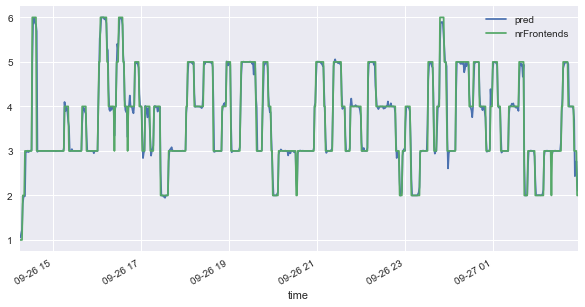

In [158]:
features.plot(y=['pred', 'nrFrontends'], figsize=(10,5), grid=True)
plt.show()

# Random data